In [ ]:
# インストール
!pip install kanjize
!pip install catboost

# インポート
import pandas as pd
import numpy as np
from kanjize import number2kanji, kanji2number
import re
import unicodedata
from sklearn.preprocessing import LabelEncoder

# 読み込み
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 結合
train_df['flg'] = -1
test_df['flg'] = -2
df = pd.concat([train_df, test_df], axis=0)





##### 前処理 #####





### Age列 ###



# 歳, 才, 際を削除
df['Age'] = df['Age'].str.replace('歳', '').str.replace('才', '').str.replace('際', '')

# 日本語と数字の年代表記を対応させる
age_mapping = {
    '10代': 15, '20代': 25, '30代': 35, '40代': 45, '50代': 55, '60代': 65,
    '１０代': 15, '２０代': 25, '３０代': 35, '４０代': 45, '５０代': 55, '６０代': 65
}

# マッピングを使ってAge_groupを設定する
df['Age_Group_Generation'] = df['Age'].map(age_mapping)

df['Age'] = df['Age'].replace({
    '10代': -1, '20代': -2, '30代': -3, '40代': -4, '50代': -5, '60代': -6,
    '１０代': -1, '２０代': -2, '３０代': -3, '４０代': -4, '５０代': -5, '６０代': -6
})


# 漢数字を数字に変換
if df['Age'].isna().any():
    # NaNを含む行は除外せず、そのまま処理を続ける
    df['Age'] = df['Age'].apply(lambda x: kanji2number(x) if isinstance(x, str) else x)
else:
    # NaNが含まれていない場合、通常通り処理を実行
    df['Age'] = df['Age'].apply(lambda x: kanji2number(x) if isinstance(x, str) else x)

# Age列をfloat型に
df['Age'] = df['Age'].astype(float)


# NaNでないか確認し、Age_Groupに対応
def age_group(age):
    if isinstance(age, float):
        if   10 <= age < 20:
            return '15'
        elif 20 <= age < 30:
            return '25'
        elif 30 <= age < 40:
            return '35'
        elif 40 <= age < 50:
            return '45'
        elif 50 <= age < 60:
            return '55'
        elif 60 <= age < 70:
            return '65'
        else:
          return np.nan

df['Age_Group'] = df['Age'].apply(age_group)

# Age_Group_Generationの値をAge_Groupに代入（NaNの場合は何もしない）
df['Age_Group'] = np.where(df['Age_Group_Generation'].notna(), df['Age_Group_Generation'], df['Age_Group'])


# 世代のAgeをあいだの値で埋める
# 元のマッピングを定義
reverse_mapping = {
    -1: 15, -2: 25, -3: 35, -4: 45, -5: 55, -6: 65
}
'''
# 世代のAgeを欠損値にする
reverse_mapping = {
    -1: np.nan, -2: np.nan, -3: np.nan, -4: np.nan, -5: np.nan, -6: np.nan
}
'''
# Age列の値を反転マッピングで置き換え
df['Age'] = df['Age'].replace(reverse_mapping)

# Age_Group_Generation列を削除
df = df.drop(columns=['Age_Group_Generation'])



### TypeofContact列 ###



# 空白を削除
df['TypeofContact'] = df['TypeofContact'].str.replace(' ', '', regex=False)

# nanを欠損値に置き換える
df['TypeofContact'] = df['TypeofContact'].replace('nan', np.nan)

# LabelEncoderのインスタンスを作成
TypeofContact = LabelEncoder()

# # ラベルエンコーディング
df['TypeofContact'] = TypeofContact.fit_transform(df['TypeofContact'])



### DurationOfPitch列 ###



def convert_duration_to_seconds(duration):
    # NaNの場合はそのまま返す
    if pd.isna(duration):
        return duration
    # 分と秒の形式を判定
    minutes_match = re.match(r'(\d+)分', duration)
    seconds_match = re.match(r'(\d+)秒', duration)

    if minutes_match:
        minutes = int(minutes_match.group(1))
        return minutes * 60
    elif seconds_match:
        seconds = int(seconds_match.group(1))
        return seconds
    else:
        # 他の形式はそのまま返す
        return duration

# 秒数に変換
df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_duration_to_seconds)



### Occupation列 ###



# LabelEncoderのインスタンスを作成
Occupation = LabelEncoder()

# ラベルエンコーディング
df['Occupation'] = Occupation.fit_transform(df['Occupation'])



### Gender列 ###



# 空白を削除
df['Gender'] = df['Gender'].str.replace(' ', '', regex=False)
df['Gender'] = df['Gender'].str.replace('\u3000', '')

# 大文字を小文字に変換
df['Gender'] = df['Gender'].str.lower()

# 全角を半角に置き換え
df['Gender'] = df['Gender'].replace('ｆｅｍａｌｅ', 'female')
df['Gender'] = df['Gender'].replace('ｍａｌｅ', 'male')

# LabelEncoderのインスタンスを作成
Gender = LabelEncoder()

# ラベルエンコーディング
df['Gender'] = Gender.fit_transform(df['Gender'])



### ProductPitched列 ###



# 空白を削除
df['ProductPitched'] = df['ProductPitched'].str.replace(' ', '', regex=False)

# 変な文字をシンプルな文字に置換
replace_dict = {
    'ᗞ': 'd', '|': 'l', 'ꓢ': 's', 'в': 'b', '×': 'x',
    'ε': 'e', 'β': 'b', 'ϲ': 'c', 'α': 'a', '𝖺': 'a', '𝙳': 'D',
    '𐊡': 'a', '𝘘': 'O', 'ꭰ': 'L', 'ｓ': 's', 'ѕ': 's', 'baѕic': 'basic',
    'ı': 'i', 'ı': 'i', 'l': 'l', 'I': 'l', '𝖽': 'd', '𝑑': 'd'
}

# 置換処理をまとめて適用
for key, value in replace_dict.items():
    df['ProductPitched'] = df['ProductPitched'].str.replace(key, value, regex=False)

# 小文字に変換
df['ProductPitched'] = df['ProductPitched'].str.lower()

# 似ている値のリスト(表記揺れ)
similar_to_basic = [
    'baslc', 'bαslc', 'basi𝘤', 'βasic', 'basiс', 'baտlc', 'вasic',
    'basιc', 'baslс', 'βaslс', 'basιс', 'baѕlc', 'βasi𝘤', 'aasi𝘤', 'aasic',
]

similar_to_standard = [
    'standar𝔡', 'staոdard', 'տtandard', 's𝘵andard', 'standarꭰ',
    'standa𝘳d', 'տtanda𝘳d', 'stan𝔡ard', 'stαndard', 's𝘵anda𝘳d', 'ѕtandard'
]

similar_to_king = [
    'klng', 'kiոg', 'kιng'
]

similar_to_deluxe = [
    'dεluxε', 'deluxε', 'ꭰeluxe'
]

similar_to_superdeluxe = [
    'ѕuperdeluxe', 'superꭰeluxe', 'superdεluxe', 'supεrꭰeluxe', 'տuperdeluxe'
]

# 本来の値に変更
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'basic' if x in similar_to_basic else x)
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'standard' if x in similar_to_standard else x)
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'king' if x in similar_to_king else x)
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'deluxe' if x in similar_to_deluxe else x)
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'superdeluxe' if x in similar_to_superdeluxe else x)

# LabelEncoderのインスタンスを作成
ProductPitched = LabelEncoder()

# ラベルエンコーディング
df['ProductPitched'] = ProductPitched.fit_transform(df['ProductPitched'])



### Designation列 ###



# 空白を削除
df['Designation'] = df['Designation'].str.replace(' ', '', regex=False)

# 似ている値のリスト
similar_to_executive = [
    'Execuｔive', 'E×ecutive', 'Executiѵе',
    'Еxecutivе', 'Exеcutivе',
    'Executivе', 'Executiѵе', 'Е×еcutive', 'Еxecutive', 'E×еcutiѵе',
    'Exеcｕtive', 'Execｕtive', 'E×ecｕtive', 'Exеcｕtivе',
    'Еxecuｔive', 'Exеcutive', 'Executiѵe', 'E×еcutiѵe', 'Exеcuｔive', 'Execｕｔive',
    'Execｕtivе', 'Еxecｕtive', 'Еxеcutivе', 'Е×ecutive', 'Exеcutiѵе'
]

similar_to_senior_manager = [
    'SeniorManage𝙝', 'SеniorManager', 'SeniorΜanαger', 'Senio𝙝Manager',
    'SeniorManagе𝙝', 'SеniorManagе𝙝', 'SeniorMαnαger', 'ЅeniorManαger',
    'SeniorMαnage𝙝', 'SеniorManagе𝙝', 'SeniorMαnager', 'Senio𝙝Manαger', 'SeniorManage𝙧',
    'ЅeniorManager', 'SeniorManagе𝙧', 'Senio𝙭Manager', 'SeniorManagеr', 'SeniorManαger',
    'SеniorManagеr', 'SeniorΜanager', 'ЅeniorΜanage𝙝', 'ՏeniorΜanager', 'ՏeniorManager',
    'Senio𝙧Manage𝙧', 'Senio𝙧Manαger', 'ЅeniorΜanage𝙧', 'Senio𝙧Manager', 'Senio𝙧Managеr', 'SеniorManagе𝙧',
    'Senio𝙧Mαnage𝙧', 'Sеnio𝙧Manager'

]

similar_to_avp = [
    'ΑVP', 'АVP', 'AVP', 'AVР', 'AVР', 'AVＰ', 'ΑVP',  'ΑVＰ', 'АVＰ'
]

similar_to_manager = [
    'Μanager', 'Managеr', 'Manαger', 'Mαnagеr', 'Mαnager', 'Mαnаger',
    'Manage𝙝', 'Managе𝙝', 'Mαnage𝙝', 'Mαnage𝙧', 'Manage𝙧', 'Μanage𝙝', 'Manαgеr',
    'Μanage𝙝', 'Manαgеr', 'Mαnαger', 'Μanagеr', 'Managе𝙝',
    'Μanage𝙧', 'Μαnager', 'Μαnagеr', 'Managе𝙧', 'Mαnαgеr'

]

similar_to_vp = [
    'VP', 'VＰ', 'VР'
]

# 本来の値に変更
df['Designation'] = df['Designation'].apply(lambda x: 'Executive' if x in similar_to_executive else x)
df['Designation'] = df['Designation'].apply(lambda x: 'SeniorManager' if x in similar_to_senior_manager else x)
df['Designation'] = df['Designation'].apply(lambda x: 'AVP' if x in similar_to_avp else x)
df['Designation'] = df['Designation'].apply(lambda x: 'Manager' if x in similar_to_manager else x)
df['Designation'] = df['Designation'].apply(lambda x: 'VP' if x in similar_to_vp else x)

# LabelEncoderのインスタンスを作成
Designation = LabelEncoder()

# ラベルエンコーディング
df['Designation'] = Designation.fit_transform(df['Designation'])



### MonthlyIncome列 ###



# 空白を削除
df['MonthlyIncome'] = df['MonthlyIncome'].str.replace(' ', '', regex=False)

# 全角数字を半角数字に変換する関数
def convert_fullwidth_to_halfwidth(value):
    if isinstance(value, str):
        return value.translate(str.maketrans(
            '０１２３４５６７８９',
            '0123456789'
        ))
    return value

# 変換を適用
df['MonthlyIncome'] = df['MonthlyIncome'].apply(convert_fullwidth_to_halfwidth)

def convert_to_yen(value):
    if isinstance(value, str):
        try:
            # 「月収」や「万円」などの単位を削除
            value = value.replace('月収', '').replace('万円', '')
            income = float(value)
            if income < 100:
                return income * 10000  # 「万円」を「円」に変換
            else:
                return income  # 「円」のまま返す
        except ValueError:
            return np.nan  # 変換できない場合はNaNを返す
    elif isinstance(value, float):
        return value  # float型の場合はそのままスルー
    else:
        return np.nan  # その他の型や欠損値の場合はNaNを返す

# 数値に変換
df['MonthlyIncome'] = df['MonthlyIncome'].apply(convert_to_yen)



### customer_info列 ###



#, 、 ／ / 全角スペースを空白に置き換え
df['customer_info'] = df['customer_info'].str.replace(',', ' ', regex=False)
df['customer_info'] = df['customer_info'].str.replace('、', ' ', regex=False)
df['customer_info'] = df['customer_info'].str.replace('／', ' ', regex=False)
df['customer_info'] = df['customer_info'].str.replace('/', ' ', regex=False)
df['customer_info'] = df['customer_info'].str.replace('\u3000', ' ', regex=False)


# 結果を元に新しい列を作成
df[['marital_status', 'car_ownership', 'children', 'NumberChildren']] = df['customer_info'].str.split(expand=True)


# 元の列を削除
df = df.drop(columns=['customer_info'])


# 結婚状況のマッピング
mapping = {
    '未婚': 'Unmarried',
    '離婚済み': 'Divorced',
    '結婚済み': 'Married',
    '独身': 'Single'
}

# 英語名に変更(文字化け防止)
df['marital_status'] = df['marital_status'].map(mapping)

# LabelEncoderのインスタンスを作成
marital_status = LabelEncoder()

# ラベルエンコーディング
df['marital_status'] = marital_status.fit_transform(df['marital_status'])


# 車のマッピング
similar_to_1 = [
    '車あり', '自家用車あり', '車所持', '車保有', '乗用車所持', '自動車所有'
]

similar_to_2 = [
    '車未所持', '自動車未所有', '車保有なし', '乗用車なし', '自家用車なし', '車なし'
]

# 本来の値に変更
df['car_ownership'] = df['car_ownership'].apply(lambda x: 1 if x in similar_to_1 else x)
df['car_ownership'] = df['car_ownership'].apply(lambda x: 0 if x in similar_to_2 else x)

# NumberChildren列の'人'を削除
df['NumberChildren'] = df['NumberChildren'].str.replace('人', '', regex=False)

# ユニークな値と対応する数字のマッピング
children_map = {
    '子供なし': 0, '子供無し': 0, '無子': 0, '子供ゼロ': 0, '非育児家庭': 0,
    '子育て状況不明': np.nan, '子の数不詳': -2, '子供の数不明': -2,
    'こども1人': 1, '1児': 1, '子供1人': 1, '子供有り(1人)': 1,
    'わからない': np.nan, '子供有り': -1,
    'こども2人': 2, '子供2人': 2, '子供有り(2人)': 2,
    'こども3人': 3, '子供3人': 3, '不明': np.nan, '2児': 2, '3児': 3,
    '子供有り(3人)': 3
}

# children列の値を数値に変換
df['children'] = df['children'].map(children_map)

df['NumberChildren'] = df.apply(
    lambda row: row['NumberChildren'] if row['children'] == -1 else
    (np.nan if pd.isna(row['children']) or row['children'] == -2 else row['children']),
    axis=1
)


# children列の値を0または１に変換
df['children'] = df['children'].map({0: 0, 1: 1, 2: 1, 3: 1, -1: 1, -2: 0})



### NumberOfTrips列 ###



# マッピング辞書を作成
mapping = {
    '年に1回': 1, '年に2回': 2, '年に3回': 3,  '年に4回': 4,
    '年に5回': 5, '年に6回': 6, '年に7回': 7, '年に8回': 8,
    '半年に1回': 2, '四半期に1回': 4
}

# 数値に変換
df['NumberOfTrips'] = df['NumberOfTrips'].apply(lambda x: mapping.get(x))





##### 相関が高い特徴量の対処 #####





# float型に
#df = df.astype(float)##########################################


'''
### Gender_male列とGender_female列(欠損値がないからただの重複) ###



# Gender_female列を削除
df = df.drop(columns=['Gender_female'])



### TypeofContact_CompanyInvited列とTypeofContact_SelfEnquiry列(相関係数1) ###




# 新しい列を作成し、片方の列が1.0であれば1.0を設定
df['TypeofContact_CompanyInvited_Merge'] = (df['TypeofContact_CompanyInvited'] > 0.0) | (df['TypeofContact_SelfEnquiry'] > 0.0)

# 片方を削除(目的変数との相関が弱く、尚且つほかの変数との相関も大きい方)
df.drop(['TypeofContact_CompanyInvited'], axis=1, inplace=True)



### Age列とAge_Group列(相関係数0.96) ###


'''
'''
何もしない
'''
'''


### ProductPitched_deluxe列とDesignation_Manager列(相関係数0.97) ###



# 新しい列を作成し、片方の列が1.0であれば1.0を設定
df['ProductPitched_deluxe_Merge'] = (df['ProductPitched_deluxe'] > 0.0) | (df['Designation_Manager'] > 0.0)

# 片方を削除(投稿したらDesignation_Managerの方が良かった)
df.drop(['Designation_Manager'], axis=1, inplace=True)



### ProductPitched_basic列とDesignation_Executive列(相関係数0.96) ###


'''
'''
何もしない
'''
'''


### Designation_SeniorManager列とProductPitched_standard列(相関係数0.95) ###



# 新しい列を作成し、片方の列が1.0であれば1.0を設定
df['Designation_SeniorManager_Merge'] = (df['Designation_SeniorManager'] > 0.0) | (df['ProductPitched_standard'] > 0.0)

# 片方を削除
df.drop(['Designation_SeniorManager'], axis=1, inplace=True)



### ProductPitched_king列とDesignation_VP列(相関係数0.87) ###



# 片方を削除
df.drop(['Designation_VP'], axis=1, inplace=True)



### children列とNumberChildren列(相関係数0.81) ###



# 片方を削除
df.drop(['children'], axis=1, inplace=True)



### NumberChildren列とNumberOfPersonVisiting列(相関係数0.52) ###



# 片方を削除
df.drop(['NumberOfPersonVisiting'], axis=1, inplace=True)



### Designation_AVP列とMonthlyIncome列(相関係数0.47) ###



# 足し算で表現
df['MonthlyIncome_Designation_AVP'] = df['Designation_AVP'] + df['MonthlyIncome']

# 片方を削除
df.drop(['MonthlyIncome'], axis=1, inplace=True)
df.drop(['Designation_AVP'], axis=1, inplace=True)



### Occupation_Small Business列とOccupation_Salaried列 ###



# 片方を削除
df.drop(['Occupation_Small Business'], axis=1, inplace=True)
'''




##### 特徴量の追加 #####





### DurationOfPitch / NumberOfFollowups ###



'''
何もしない
'''



### PreferredPropertyStar / CityTier ###



'''
何もしない
'''



### DurationPitch / MonthlyIncome ###



'''
from sklearn.preprocessing import MinMaxScaler

# MinMaxScalerのインスタンスを作成
scaler = MinMaxScaler()

# 'DurationOfPitch' と 'MonthlyIncome' をスケーリング
scaled_values = scaler.fit_transform(df[['DurationOfPitch', 'MonthlyIncome']])

# スケーリングされたデータを新しいデータフレームに変換
scaled_df = pd.DataFrame(scaled_values, columns=['DurationOfPitch_scaled', 'MonthlyIncome_scaled'])

# 新しい特徴量を生成
df['DurationPitch_MonthlyIncome'] = scaled_df['DurationOfPitch_scaled'] / scaled_df['MonthlyIncome_scaled']

# 元のデータフレームにスケーリングされた列を追加
df = pd.merge(df, scaled_df, left_index=True, right_index=True)

# 不要な列を削除
df = df.drop(columns=['DurationOfPitch_scaled', 'MonthlyIncome_scaled'])

# 結果を表示
print(df)
'''



### 四則演算 ###



'''
# MonthlyIncome + Age
df['MonthlyIncome'] = df['MonthlyIncome'] + df['Age']
# Ageを削除
df.drop(['Age'], axis=1, inplace=True)

#MonthlyIncome + NumberOfTrips
df['MonthlyIncome'] = df['MonthlyIncome'] + df['NumberOfTrips']
# NumberOfTripsを削除
df.drop(['NumberOfTrips'], axis=1, inplace=True)

# Age - NumberChildren
df['Age_NumberChildren'] = df['Age'] - df['NumberChildren']
# NumberChildrenを削除
df.drop(['NumberChildren'], axis=1, inplace=True)
'''



### カテゴリー列の合成 ###



'''
# 新しい列を作成して、DesignationとProductPitchedの値を左右に並べる
df['Designation'] = df['Designation'].astype(str)
df['ProductPitched'] = df['ProductPitched'].astype(str)
df['Designation_ProductPitched'] = df['Designation'] + ' - ' + df['ProductPitched']

# NumberOfFollowupsとDesignation
df['Designation'] = df['Designation'].astype(str)
df['NumberOfFollowups'] = df['NumberOfFollowups'].astype(str)

df['NumberOfFollowups_Designation'] = df['NumberOfFollowups'] + ' - ' + df['Designation']
# 片方を削除
df.drop(['Designation'], axis=1, inplace=True)

# car_ownership - NumberChildren
df['NumberChildren_car_ownerchip'] = df['car_ownership'] - df['NumberChildren']
# NumberOfTripsを削除
df.drop(['car_ownership'], axis=1, inplace=True)

# Age - NumberOfPersonVisiting
df['Age'] = df['Age'] - df['NumberOfPersonVisiting']
# NumberOfPersonVisitingを削除
df.drop(['NumberOfPersonVisiting'], axis=1, inplace=True)
'''





##### 欠損値の処理 #####





# dfの欠損値を中央値で埋める関数（flg == -2 の行の中央値を使用）
'''
def fill_missing_values_with_median(df, exclude_cols):
    # 処理対象の列を選択
    cols_to_fill = [col for col in df.columns if col not in exclude_cols]

    # flg == -2 の行を選択
    df_flg_minus2 = df[df['flg'] == -1]

    # flg == -2 の行の中央値を計算
    median_values = df_flg_minus2[cols_to_fill].median()

    # 各列の中央値で欠損値を埋める
    for col in cols_to_fill:
        if pd.api.types.is_numeric_dtype(df[col]):  # 数値データ型の列のみ処理
            df[col].fillna(median_values[col], inplace=True)

    return df
'''
'''
def fill_missing_values_with_catboost(df, target_col, exclude_cols, cat_features):
    """
    CatBoostモデルを使用して欠損値を予測値で埋める関数

    Parameters:
    - df: 欠損値を含むDataFrame
    - target_col: 欠損値を予測するためのターゲット列名
    - exclude_cols: 処理対象外の列名のリスト
    - cat_features: カテゴリ変数の列名リスト

    Returns:
    - df: 欠損値を予測値で埋めたDataFrame
    """
    # 処理対象の列を選択
    cols_to_fill = [col for col in df.columns if col not in exclude_cols + [target_col]]

    # 確認のための出力
    print(f"カテゴリ変数: {cat_features}")
    print(f"対象となる特徴量: {cols_to_fill}")

    for col in df.columns:
        if col != target_col and df[col].isnull().any():
            # 欠損値がある場合の処理
            train_data = df.dropna(subset=[target_col])
            train_X = train_data[cols_to_fill]
            train_y = train_data[target_col]

            # データの分割
            X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.1, random_state=42)

            # CatBoostモデルの作成
            model = CatBoostClassifier(
                iterations=100,
                learning_rate=0.09,
                depth=6,
                cat_features=[feature for feature in cat_features if feature in cols_to_fill],
                verbose=False
            )

            # モデルの訓練
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

            # 欠損値があるデータを予測
            missing_data = df[df[col].isnull()]
            missing_X = missing_data[cols_to_fill]
            predicted_values = model.predict(missing_X)

            # 予測値で欠損値を埋める
            df.loc[df[col].isnull(), col] = predicted_values

    return df

# 欠損値をCatBoostで埋める関数を呼び出す

df = fill_missing_values_with_catboost(df, 'ProdTaken', exclude_cols, exclude_cols)
'''
# dfの欠損値を中央値で埋める関数
def fill_missing_values_with_median(df, exclude_cols):
    # 処理対象の列を選択
    cols_to_fill = [col for col in df.columns if col not in exclude_cols]

    # 各列の中央値で欠損値を埋める
    for col in cols_to_fill:
        if pd.api.types.is_numeric_dtype(df[col]):  # 数値データ型の列のみ処理
            df[col].fillna(df[col].median(), inplace=True)

    return df

# 欠損値をunknownで埋める関数
def fill_missing_with_unknown(df, cat_features):
    for feature in cat_features:
        df[feature].fillna('unknown', inplace=True)

# 処理対象外の列
exclude_cols = ['TypeofContact', 'Occupation', 'Gender', 'Designation', 'ProductPitched', 'marital_status']

# カテゴリ変数を指定
cat_features = ['TypeofContact', 'Occupation', 'Gender', 'Designation', 'ProductPitched', 'marital_status'
]

# dfの欠損値を中央値で埋める
df = fill_missing_values_with_median(df, exclude_cols)

# Age_Groupの欠損値を-1に
df['Age_Group'] = df['Age_Group'].fillna(-50)
# NumberChildrenの欠損値を-1に
df['NumberChildren'] = df['NumberChildren'].fillna(-50)





##### データ型の修正 #####





# NumberOfTrips
df['NumberOfTrips'] = df['NumberOfTrips'].astype(int)
# NumberOfPersonVisiting
df['NumberOfPersonVisiting'] = df['NumberOfPersonVisiting'].astype(int)
# Age
df['Age'] = df['Age'].astype(int)
# children
df['children'] = df['children'].astype(int)
# NumberOfFollowups
df['NumberOfFollowups'] = df['NumberOfFollowups'].astype(int)
# PreferredPropertyStar
df['PreferredPropertyStar'] = df['PreferredPropertyStar'].astype(int)
# Age_Group
df['Age_Group'] = df['Age_Group'].astype(int)
# NumberChildren
df['NumberChildren'] = df['NumberChildren'].astype(int)





##### データを再分割して表示 #####





# 再分割
train_df = df[df['flg'] == -1]
test_df = df[df['flg'] == -2]

# flg列を削除
train_df = train_df.drop(columns=['flg'])
test_df = test_df.drop(columns=['flg'])

#すべての列を表示するオプション
pd.set_option('display.max_columns', None)
# データの確認
display(df.head())
display(train_df.head())
display(test_df.head())


  Using cached catboost-1.2.5-cp310-cp310-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached catboost-1.2.5-cp310-cp310-manylinux2014_x86_64.whl (98.2 MB)


,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,flg,Age_Group,marital_status,car_ownership,children,NumberChildren
0,0,50,1,2,900.0,0,1,1,4,0,3,3,1,4,1,253905.0,1.0,-1,55,3,0,0,0
1,1,56,0,1,840.0,1,1,1,4,3,3,3,1,4,3,404475.0,0.0,-1,55,0,1,0,0
2,2,38,1,1,600.0,0,0,1,3,0,3,3,0,4,1,278145.0,1.0,-1,-50,1,0,0,0
3,3,37,1,2,1080.0,2,0,1,3,3,4,3,0,5,3,326805.0,0.0,-1,35,0,1,0,0
4,4,48,0,3,1020.0,2,0,1,3,0,4,3,0,4,1,258435.0,1.0,-1,45,2,1,0,0


,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,Age_Group,marital_status,car_ownership,children,NumberChildren
0,0,50,1,2,900.0,0,1,1,4,0,3,3,1,4,1,253905.0,1.0,55,3,0,0,0
1,1,56,0,1,840.0,1,1,1,4,3,3,3,1,4,3,404475.0,0.0,55,0,1,0,0
2,2,38,1,1,600.0,0,0,1,3,0,3,3,0,4,1,278145.0,1.0,-50,1,0,0,0
3,3,37,1,2,1080.0,2,0,1,3,3,4,3,0,5,3,326805.0,0.0,35,0,1,0,0
4,4,48,0,3,1020.0,2,0,1,3,0,4,3,0,4,1,258435.0,1.0,45,2,1,0,0


,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,Age_Group,marital_status,car_ownership,children,NumberChildren
0,3489,48,1,2,780.0,2,1,1,4,4,3,3,0,3,0,496950.0,0.0,45,1,1,0,0
1,3490,35,1,2,720.0,2,0,1,4,3,3,3,1,3,3,300000.0,0.0,35,1,0,0,0
2,3491,25,1,1,540.0,1,0,1,4,0,3,3,0,3,1,260000.0,0.0,25,0,0,0,0
3,3492,21,0,2,420.0,1,1,1,4,0,4,3,0,3,3,259875.0,0.0,25,0,1,0,0
4,3493,41,0,1,420.0,1,1,1,4,0,3,3,0,4,1,268830.0,0.0,45,2,1,0,0


Train DataFrame Basic Statistics (excluding specified columns):


,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,Age_Group,car_ownership,children,NumberChildren
count,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,1744.000000,39.396102,1.697048,857.884781,0.591574,2.394669,7.729722,3.441101,3.035254,0.102608,2.513901,355453.141301,0.142448,37.404700,0.488392,0.712812,0.454858
std,1007.331872,9.781128,0.671500,410.226215,0.491613,0.726612,39.313067,0.599633,0.669337,0.303490,1.115412,74586.935646,0.349559,18.048614,0.499937,0.452515,5.281663
min,0.000000,15.000000,1.000000,240.000000,0.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,200000.000000,0.000000,-50.000000,0.000000,0.000000,-50.000000
25%,872.000000,32.000000,1.000000,540.000000,0.000000,2.000000,3.000000,3.000000,3.000000,0.000000,2.000000,300435.000000,0.000000,35.000000,0.000000,0.000000,0.000000
50%,1744.000000,38.000000,2.000000,780.000000,1.000000,2.000000,4.000000,3.000000,3.000000,0.000000,2.000000,342075.000000,0.000000,35.000000,0.000000,1.000000,1.000000
75%,2616.000000,47.000000,2.000000,960.000000,1.000000,3.000000,4.000000,4.000000,3.000000,0.000000,3.000000,400000.000000,0.000000,45.000000,1.000000,1.000000,2.000000
max,3488.000000,65.000000,3.000000,2160.000000,1.000000,4.000000,600.000000,5.000000,8.000000,1.000000,5.000000,600000.000000,1.000000,65.000000,1.000000,1.000000,3.000000



Test DataFrame Basic Statistics (excluding specified columns):


,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,Age_Group,car_ownership,children,NumberChildren
count,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.0,3489.000000,3489.000000,3489.000000,3489.000000
mean,5233.000000,39.151906,1.682717,871.728289,0.617369,2.407567,6.830037,3.431929,3.020923,0.095156,2.500143,356387.248495,0.0,37.334480,0.474348,0.727429,0.489825
std,1007.331872,9.812600,0.671710,420.013952,0.486099,0.741628,34.770785,0.599618,0.669081,0.293473,1.153904,76594.114226,0.0,17.630661,0.499413,0.445346,5.284831
min,3489.000000,15.000000,1.000000,240.000000,0.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,200000.000000,0.0,-50.000000,0.000000,0.000000,-50.000000
25%,4361.000000,32.000000,1.000000,540.000000,0.000000,2.000000,3.000000,3.000000,3.000000,0.000000,2.000000,300000.000000,0.0,35.000000,0.000000,0.000000,0.000000
50%,5233.000000,38.000000,2.000000,780.000000,1.000000,2.000000,4.000000,3.000000,3.000000,0.000000,2.000000,342075.000000,0.0,35.000000,0.000000,1.000000,1.000000
75%,6105.000000,46.000000,2.000000,960.000000,1.000000,3.000000,4.000000,4.000000,3.000000,0.000000,3.000000,400000.000000,0.0,45.000000,1.000000,1.000000,2.000000
max,6977.000000,61.000000,3.000000,2160.000000,1.000000,4.000000,500.000000,5.000000,8.000000,1.000000,5.000000,600000.000000,0.0,65.000000,1.000000,1.000000,3.000000



Train DataFrame Info (excluding specified columns):
<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3488
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3489 non-null   int64  
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3489 non-null   float64
 5   Occupation              3489 non-null   int64  
 6   Gender                  3489 non-null   int64  
 7   NumberOfPersonVisiting  3489 non-null   int64  
 8   NumberOfFollowups       3489 non-null   int64  
 9   ProductPitched          3489 non-null   int64  
 10  PreferredPropertyStar   3489 non-null   int64  
 11  NumberOfTrips           3489 non-null   int64  
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64

None


Test DataFrame Info (excluding specified columns):
<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3488
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3489 non-null   int64  
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3489 non-null   float64
 5   Occupation              3489 non-null   int64  
 6   Gender                  3489 non-null   int64  
 7   NumberOfPersonVisiting  3489 non-null   int64  
 8   NumberOfFollowups       3489 non-null   int64  
 9   ProductPitched          3489 non-null   int64  
 10  PreferredPropertyStar   3489 non-null   int64  
 11  NumberOfTrips           3489 non-null   int64  
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64 

None

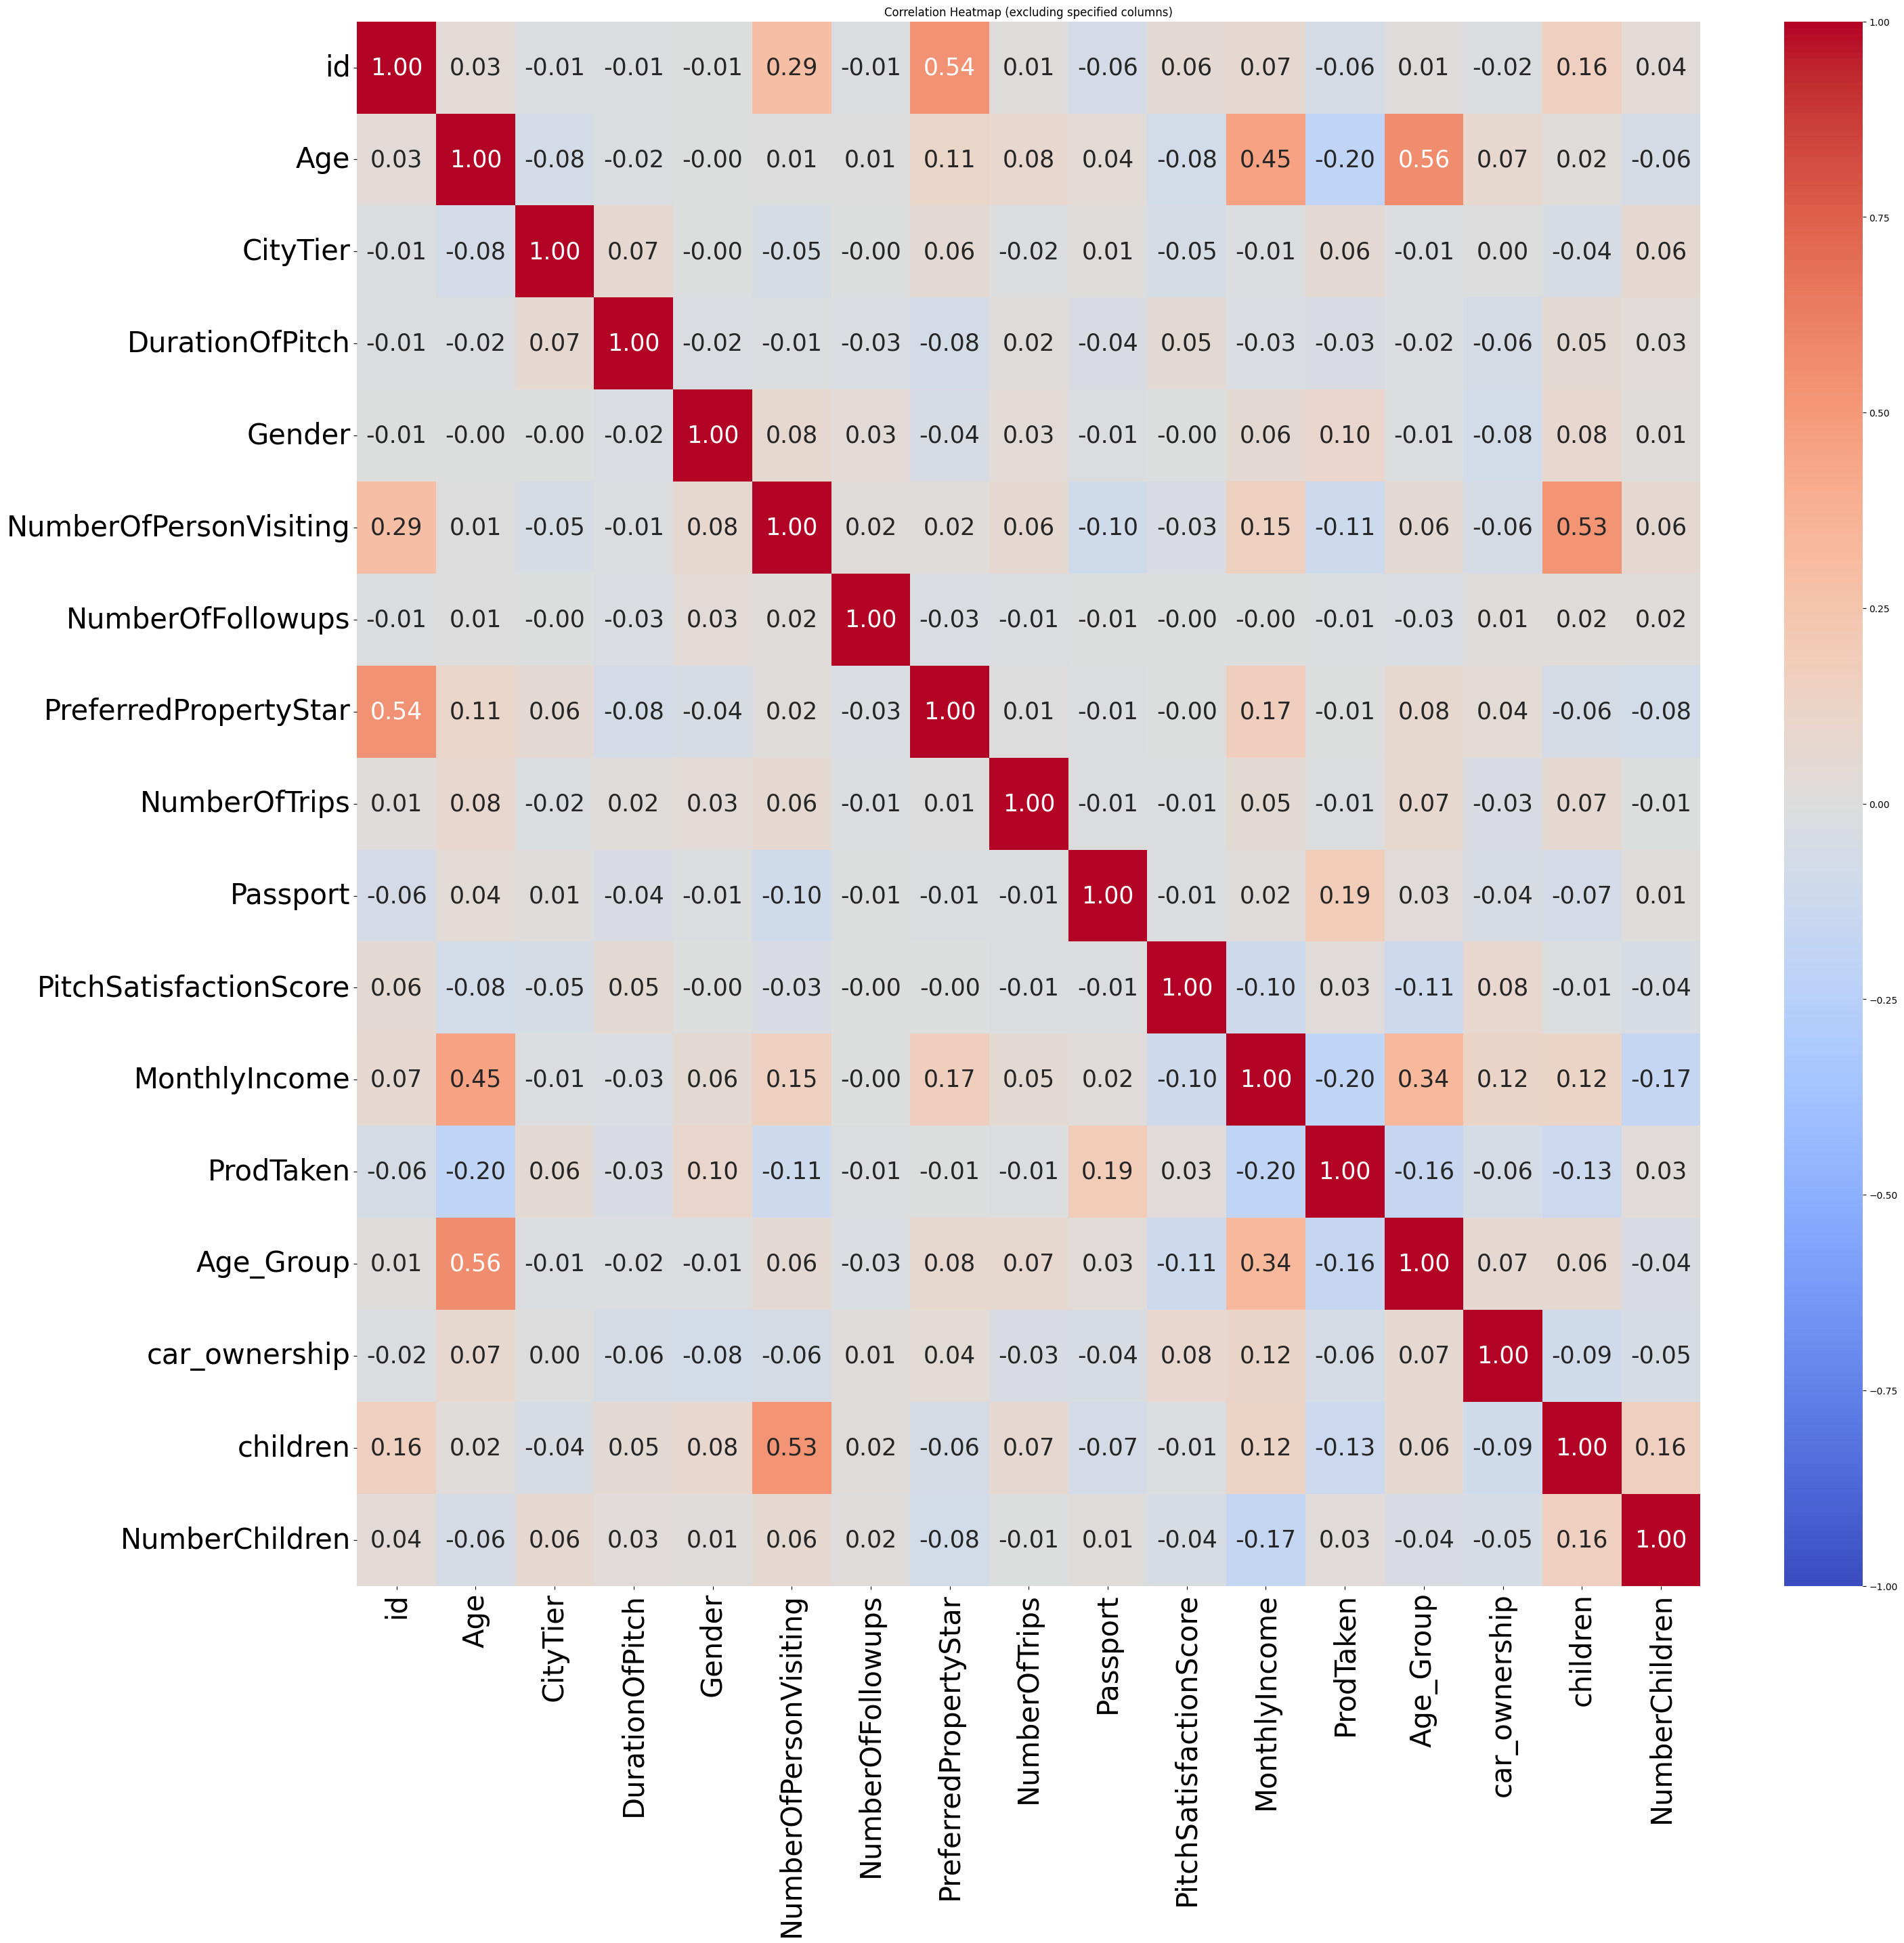

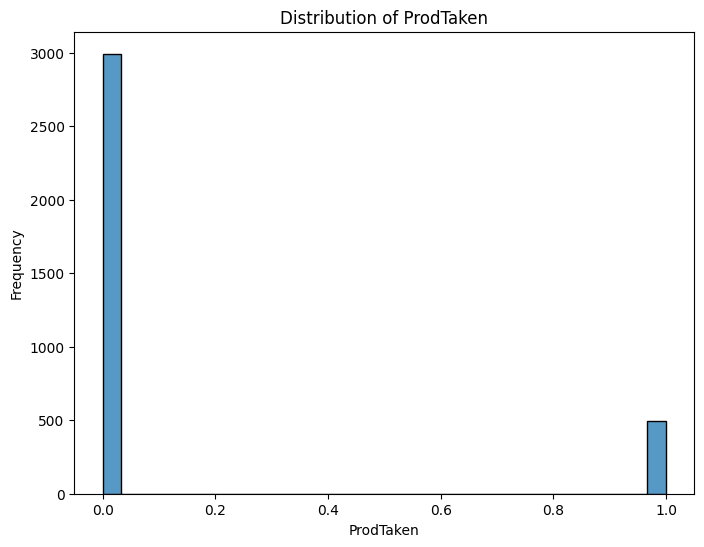

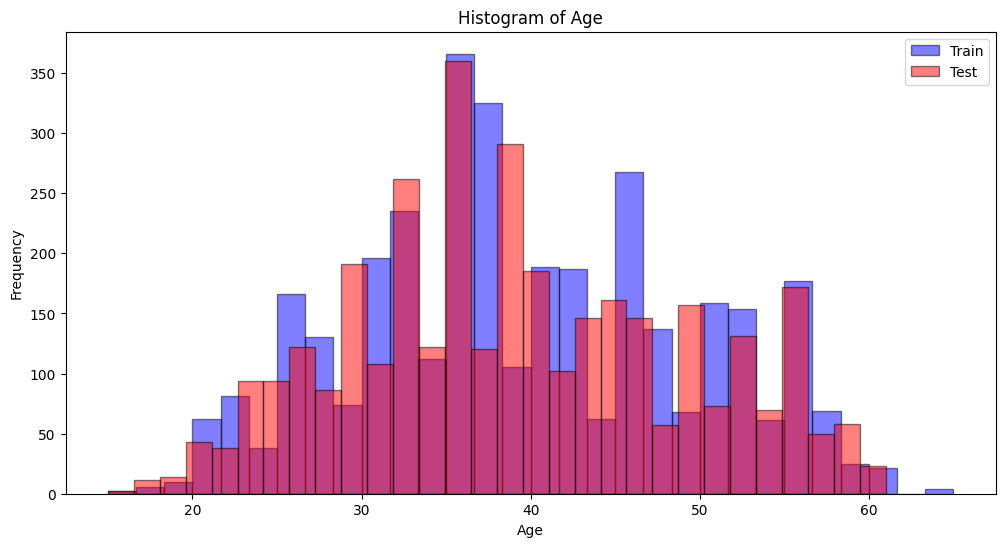

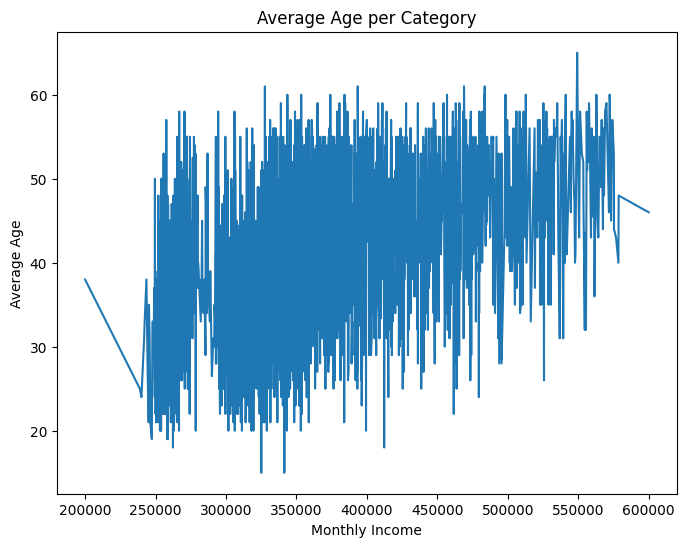

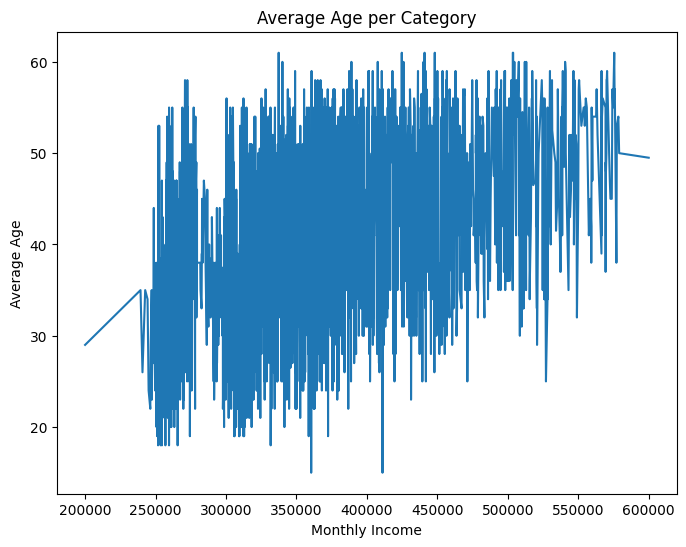

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 除外する列を指定
exclude_cols = ['TypeofContact', 'Occupation', 'Designation', 'ProductPitched', 'marital_status']

# 除外列を持たないデータフレームを作成
train_df_filtered = train_df.drop(columns=exclude_cols)
test_df_filtered = test_df.drop(columns=exclude_cols)

# 基本統計量の表示
print("Train DataFrame Basic Statistics (excluding specified columns):")
display(train_df_filtered.describe())

print("\nTest DataFrame Basic Statistics (excluding specified columns):")
display(test_df_filtered.describe())

# データフレームの情報の表示
print("\nTrain DataFrame Info (excluding specified columns):")
display(train_df.info())

print("\nTest DataFrame Info (excluding specified columns):")
display(test_df.info())

# 相関行列の計算
correlation_matrix = train_df_filtered.corr()

# ヒートマップの表示
plt.figure(figsize=(32, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 25})
plt.title('Correlation Heatmap (excluding specified columns)')
# 軸ラベルのサイズを調整
plt.xticks(fontsize=30)  # x軸ラベルのサイズ
plt.yticks(fontsize=30)  # y軸ラベルのサイズ
plt.show()

# 目的変数のヒストグラムの表示(train_df)
plt.figure(figsize=(8, 6))
sns.histplot(train_df['ProdTaken'], kde=False, bins=30)
plt.title('Distribution of ProdTaken')
plt.xlabel('ProdTaken')
plt.ylabel('Frequency')
plt.show()


# 'Age'列のヒストグラムをプロット
plt.figure(figsize=(12, 6))

# train_dfのヒストグラム
plt.hist(train_df['Age'], bins=30, alpha=0.5, label='Train', color='blue', edgecolor='black')

# test_dfのヒストグラム
plt.hist(test_df['Age'], bins=30, alpha=0.5, label='Test', color='red', edgecolor='black')

# グラフのタイトルとラベル
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# 凡例の表示
plt.legend()

# グラフを表示
plt.show()







# 各カテゴリーごとにAge列の平均値を計算
mean_age_per_category = train_df.groupby('MonthlyIncome')['Age'].mean()

# 平均値を使って折れ線グラフを描画
plt.figure(figsize=(8, 6))
mean_age_per_category.plot(kind='line')
plt.title('Average Age per Category')
plt.xlabel('Monthly Income')
plt.ylabel('Average Age')
plt.show()

# 各カテゴリーごとにAge列の平均値を計算
mean_age_per_category = test_df.groupby('MonthlyIncome')['Age'].mean()

# 平均値を使って折れ線グラフを描画
plt.figure(figsize=(8, 6))
mean_age_per_category.plot(kind='line')
plt.title('Average Age per Category')
plt.xlabel('Monthly Income')
plt.ylabel('Average Age')
plt.show()


クロスバリデーションのAUCスコア: 0.8308


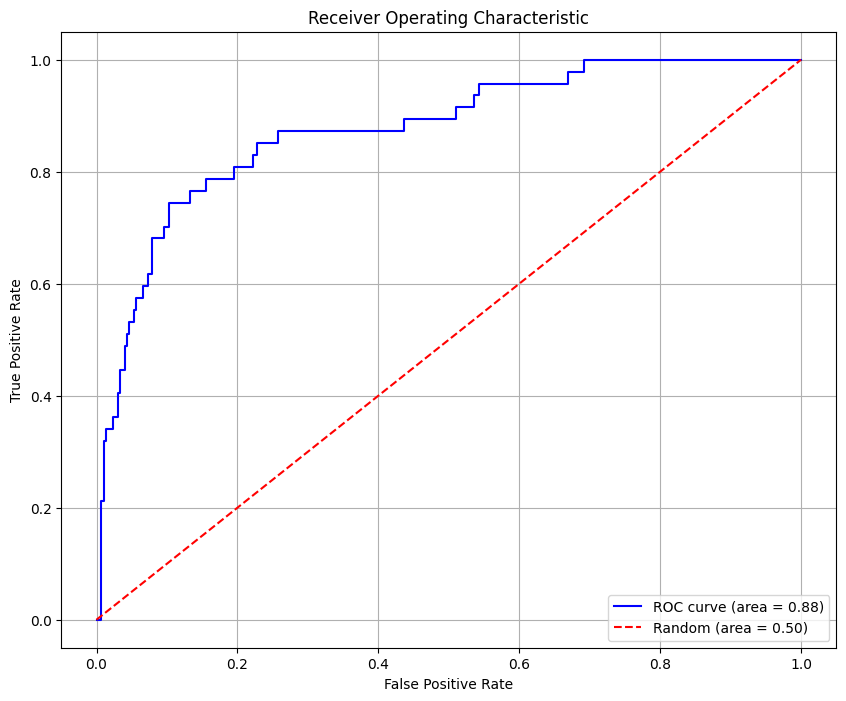

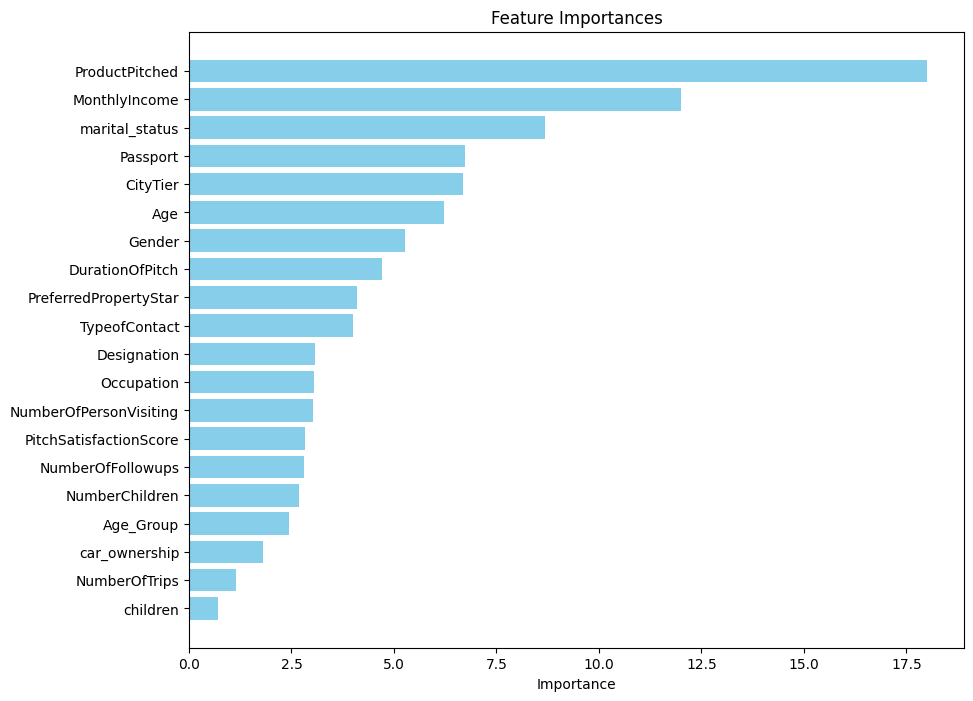

Make_filing_Success!


In [ ]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# データの準備
X = train_df.drop(columns=['id', 'ProdTaken'])
y = train_df['ProdTaken']

# カテゴリ変数を指定
cat_features = ['TypeofContact', 'Occupation', 'marital_status'
, 'Age_Group', 'PreferredPropertyStar', 'PitchSatisfactionScore', 'Passport', 'CityTier', 'ProductPitched'
, 'NumberOfFollowups', 'Designation', 'Gender'
#, 'NumberChildren', 'car_ownership', 'NumberOfPersonVisiting', 'NumberOfTrips', 'children'
]

# データの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# CatBoostモデルの作成
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.09,
    depth=6,
    cat_features=cat_features,  # カテゴリ変数を指定
    verbose=False,
    # L2正則化
    l2_leaf_reg=3,
)

# クロスバリデーションでのAUCスコア評価
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'クロスバリデーションのAUCスコア: {cv_scores.mean():.4f}')

# モデルの訓練
model.fit(X_train, y_train)

# モデルの予測確率を取得
y_proba = model.predict_proba(X_valid)[:, 1]
fpr, tpr, _ = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)

# ランダムな予測のROC曲線（直線）を作成
random_fpr = [0, 1]
random_tpr = [0, 1]
random_auc = auc(random_fpr, random_tpr)

# ROC曲線をプロット
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot(random_fpr, random_tpr, color='red', linestyle='--', label=f'Random (area = {random_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 特徴量の重要度を表示
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# 特徴量の重要度をヒストグラムで表示
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 降順に表示
plt.show()

# テストデータの予測
test_features = test_df.drop(columns=['id', 'ProdTaken'])
probabilities = model.predict_proba(test_features)

# IDと予測確率のDataFrameを作成
output = pd.DataFrame({
    'id': test_df['id'],
    'probability': probabilities[:, 1]  # クラス1の確率
})

# CSVファイルとして保存（ヘッダー無し）
output.to_csv('SignateCup2024_No_SMOTE.csv', index=False, header=False)
print('Make_filing_Success!')


In [ ]:
'''
# test_dfが全て異常値であるため、異常値であるかないかフラグ列を追加(IQR法)
def detect_outliers_iqr(df):
    outliers = pd.DataFrame()
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outliers

def add_outlier_flags(df, outliers):
    # 各列に対して異常値フラグを追加
    for col in outliers.columns:
        df[col + '_outlier'] = outliers[col].astype(int)  # Trueを1、Falseを0に変換
    return df

# 異常値を検出
train_outliers = detect_outliers_iqr(train_df)
test_outliers = detect_outliers_iqr(test_df)

# 異常値フラグを追加
train_df = add_outlier_flags(train_df, train_outliers)
test_df = add_outlier_flags(test_df, test_outliers)

# 異常値フラグと目的変数の相関を確認
correlations = train_df.filter(like='_outlier').corrwith(train_df['ProdTaken'])
print(correlations)

# ProdTaken_outlier列を削除(目的変数との相関が1)
train_df = train_df.drop(columns=['ProdTaken_outlier'])
test_df = test_df.drop(columns=['ProdTaken_outlier'])
'''


"\n# test_dfが全て異常値であるため、異常値であるかないかフラグ列を追加(IQR法)\ndef detect_outliers_iqr(df):\n    outliers = pd.DataFrame()\n    for col in df.select_dtypes(include=['number']).columns:\n        Q1 = df[col].quantile(0.25)\n        Q3 = df[col].quantile(0.75)\n        IQR = Q3 - Q1\n        lower_bound = Q1 - 1.5 * IQR\n        upper_bound = Q3 + 1.5 * IQR\n        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound))\n    return outliers\n\ndef add_outlier_flags(df, outliers):\n    # 各列に対して異常値フラグを追加\n    for col in outliers.columns:\n        df[col + '_outlier'] = outliers[col].astype(int)  # Trueを1、Falseを0に変換\n    return df\n\n# 異常値を検出\ntrain_outliers = detect_outliers_iqr(train_df)\ntest_outliers = detect_outliers_iqr(test_df)\n\n# 異常値フラグを追加\ntrain_df = add_outlier_flags(train_df, train_outliers)\ntest_df = add_outlier_flags(test_df, test_outliers)\n\n# 異常値フラグと目的変数の相関を確認\ncorrelations = train_df.filter(like='_outlier').corrwith(train_df['ProdTaken'])\nprint(correlations)\n\n# ProdTak

Seed 42のクロスバリデーションの平均AUCスコア: 0.8279
Seed 84のクロスバリデーションの平均AUCスコア: 0.8295
Seed 126のクロスバリデーションの平均AUCスコア: 0.8276
Seed 168のクロスバリデーションの平均AUCスコア: 0.8323
Seed 210のクロスバリデーションの平均AUCスコア: 0.8255
Seed 252のクロスバリデーションの平均AUCスコア: 0.8316
Seed 294のクロスバリデーションの平均AUCスコア: 0.8310
Seed 336のクロスバリデーションの平均AUCスコア: 0.8328
Seed 378のクロスバリデーションの平均AUCスコア: 0.8329
Seed 420のクロスバリデーションの平均AUCスコア: 0.8282
全シードのクロスバリデーションの平均AUCスコア: 0.8299


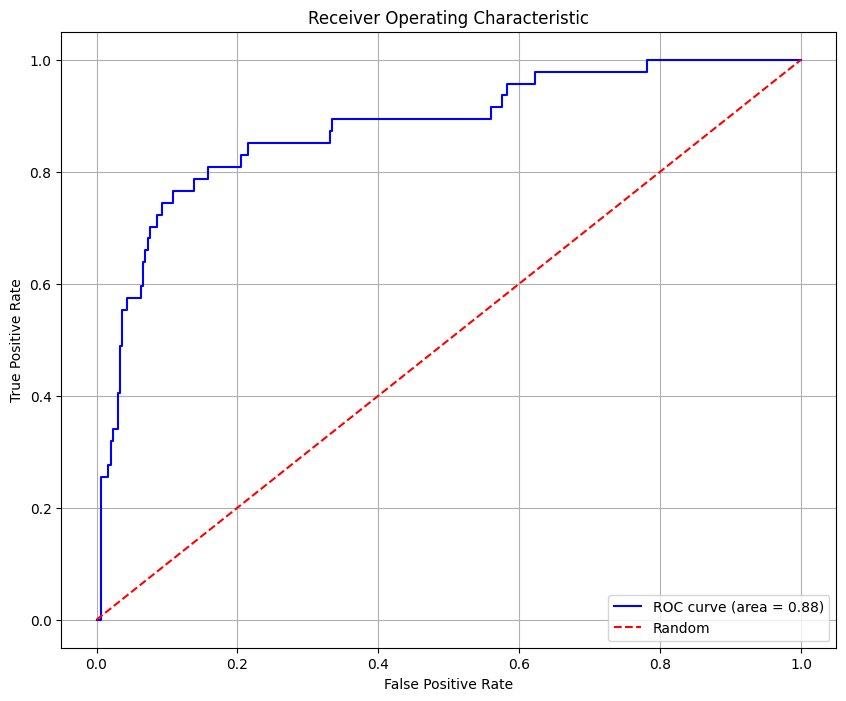

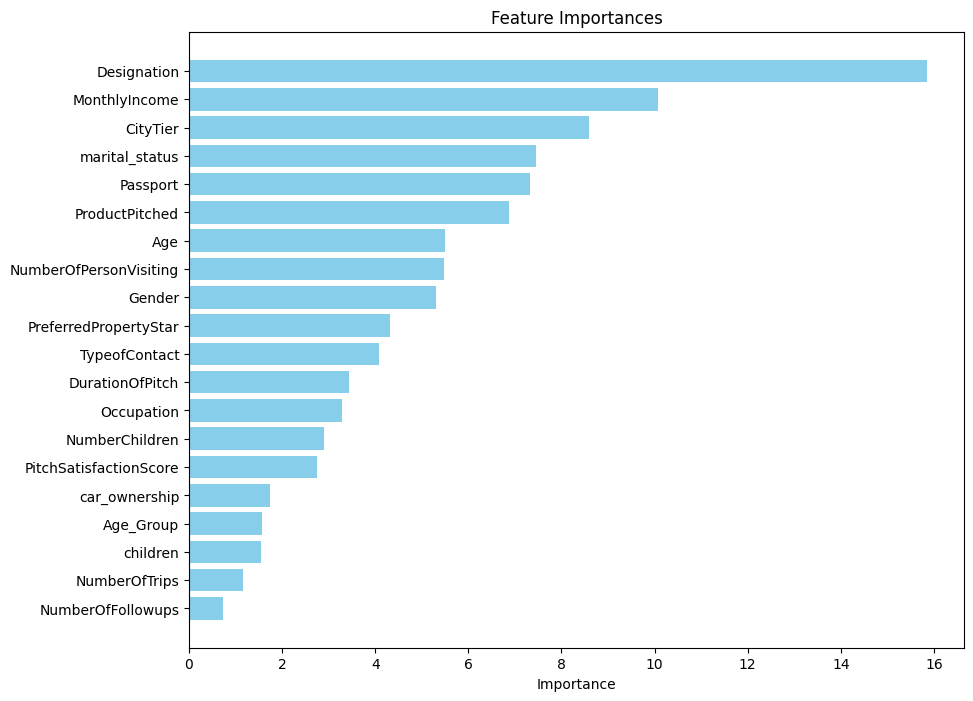

Make_filing_Success!


In [ ]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# データの準備
X = train_df.drop(columns=['id', 'ProdTaken'])
y = train_df['ProdTaken']

# カテゴリ変数を指定
cat_features = ['TypeofContact', 'Occupation', 'marital_status', 'Age_Group', 'PreferredPropertyStar',
                'PitchSatisfactionScore', 'Passport', 'CityTier', 'ProductPitched',
                'NumberOfFollowups', 'Designation', 'Gender']

# データの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# シードアベレージングの準備
seeds = [42, 84, 126, 168, 210, 252, 294, 336, 378, 420]  # 10個のシードを指定
all_cv_scores = []

for seed in seeds:
    # CatBoostモデルの作成
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.09,
        depth=6,
        cat_features=cat_features,
        verbose=False,
        l2_leaf_reg=3,
        random_seed=seed  # 各シードを設定
    )

    # クロスバリデーションでのAUCスコア評価
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    all_cv_scores.append(cv_scores.mean())

# シードごとのクロスバリデーションの平均を表示
for i, seed in enumerate(seeds):
    print(f'Seed {seed}のクロスバリデーションの平均AUCスコア: {all_cv_scores[i]:.4f}')

# 全シードの平均スコアを計算して表示
mean_cv_score = np.mean(all_cv_scores)
print(f'全シードのクロスバリデーションの平均AUCスコア: {mean_cv_score:.4f}')

# モデルの訓練とROC曲線のプロット
predictions = np.zeros(len(X_valid))
probabilities = np.zeros(len(test_df))

for seed in seeds:
    # 再度モデルをトレーニング
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.09,
        depth=6,
        cat_features=cat_features,
        verbose=False,
        l2_leaf_reg=3,
        random_seed=seed
    )
    model.fit(X_train, y_train)

    # 検証データの予測確率を取得
    y_proba = model.predict_proba(X_valid)[:, 1]
    predictions += y_proba / len(seeds)  # 平均化

    # テストデータの予測確率を取得
    test_proba = model.predict_proba(test_df.drop(columns=['id', 'ProdTaken']))[:, 1]
    probabilities += test_proba / len(seeds)  # 平均化

# ROC曲線のプロット
fpr, tpr, _ = roc_curve(y_valid, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 特徴量の重要度を表示
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 降順に表示
plt.show()

# テストデータの予測結果を保存
output = pd.DataFrame({
    'id': test_df['id'],
    'probability': probabilities  # 平均化された確率を使用
})

output.to_csv('SignateCup2024_SeedAveraging.csv', index=False, header=False)
print('Make_filing_Success!')
